# Isotropic Power Spectrum

In this notebook, we are going to look at some simulations that we have available and analyze some of the statistical properties of the datasets. 

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])

# append to path
sys.path.append(str(root))

In [2]:
import math
from pathlib import Path

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Altitools
from alti_tools._src.data.ssh import download_ssh_toy
from alti_tools._src.transforms import spatial, temporal, psd as psd_transform
from alti_tools._src.viz import psd as psd_plots


import seaborn as sns
import corner

sns.set_context(context="talk", font_scale=0.7)

try:
    import powerspec as ps
except ModuleNotFoundError:
    !pip install powerspec
    import powerspec as ps  

import xarray as xr
import pandas as pd
from scipy import ndimage
import xrft
from dask.diagnostics import ProgressBar

import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## NATL60 Data

### Sea Surface Height

* [Source](https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/catalog/meomopendap/extract/ocean-data-challenges/dc_data1/dc_ref/catalog.html)

In [3]:
# download_ssh_toy("natl60")

In [4]:
# # get directoru
# data_path = Path("/Users/eman/.CMVolumes/cal1_workdir/data/dc_2020/dc_ref")

# # list all files in directory
# data_names = list(data_path.glob("*.nc"))

# # sample name
# data_name = data_path.joinpath("NATL60-CJM165_GULFSTREAM_y2012*.nc")

In [3]:
# ds_grid = xr.open_mfdataset(data_names[:1], engine="netcdf4")
ds_grid = xr.open_dataset("/Volumes/EMANS_HDD/data/osse_oceanix/raw/sim/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc", decode_times=False).assign_coords(time=lambda ds: pd.to_datetime(ds.time))

ds_grid

<xarray.Dataset>
Dimensions:  (time: 365, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    ssh      (time, lat, lon) float64 ...

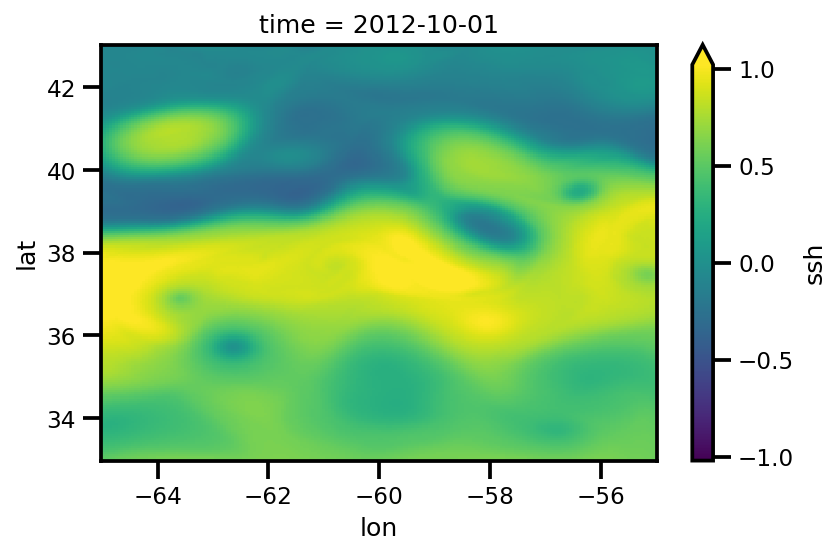

In [4]:
fig, ax = plt.subplots()

ds_grid.isel(time=0).ssh.plot(ax=ax, cmap="viridis", robust=True)

plt.tight_layout()
plt.show()

In [5]:
# open dataset
# ds_grid = xr.open_mfdataset(data_names[:1], engine="netcdf4")
ds_grid = xr.open_dataset("/Volumes/EMANS_HDD/data/osse_oceanix/raw/sim/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc", decode_times=False).assign_coords(time=lambda ds: pd.to_datetime(ds.time))


ds_ssh = ds_grid.ssh

# convert lat/lon, degrees -> meters
ds_ssh = spatial.coords_degree_2_meters(ds_ssh)


# convert time stamps -> days
ds_ssh = temporal.coords_temporal_normalize(ds_ssh, np.timedelta64(1, "D"))

In [6]:
ds_ssh

<xarray.DataArray 'ssh' (time: 365, lat: 201, lon: 201)>
[14746365 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -7.215e+03 -7.209e+03 ... -6.111e+03 -6.105e+03
  * lat      (lat) float64 3.663e+03 3.669e+03 3.674e+03 ... 4.767e+03 4.773e+03
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0

In [17]:
# open dataset
# ds_grid = xr.open_mfdataset(data_names[:1], engine="netcdf4")
ds_grid = xr.open_dataset("/Volumes/EMANS_HDD/data/osse_oceanix/raw/sim/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc", decode_times=False).assign_coords(time=lambda ds: pd.to_datetime(ds.time))


ds_ssh = ds_grid.ssh

# convert lat/lon, degrees -> meters
ds_ssh = spatial.coords_degree_2_meters(ds_ssh)

# rescale spatial steps
ds_ssh.coords["lon"] = ds_ssh.coords["lon"] - ds_ssh.coords["lon"][0]
ds_ssh.coords["lat"] = ds_ssh.coords["lat"] - ds_ssh.coords["lat"][0]

# convert time stamps -> days
ds_ssh = temporal.coords_temporal_normalize(ds_ssh, np.timedelta64(1, "D"))

In [18]:
ds_ssh

<xarray.DataArray 'ssh' (time: 365, lat: 201, lon: 201)>
[14746365 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 0.0 5.55e+03 1.11e+04 ... 1.104e+06 1.11e+06
  * lat      (lat) float64 0.0 5.55e+03 1.11e+04 ... 1.104e+06 1.11e+06
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0

In [19]:
# ds_psd = psd_transform.isotropic_power_spectrum(ds_ssh)
ds_psd = psd_transform.isotropic_power_spectrum_dask(ds_ssh)

[########################################] | 100% Completed |  9.5s


In [20]:
ds_psd.attrs["label"] = "Sea Surface Height"

#### Wavenumber

$$
\mathbf{\lambda}, k_r
$$

In [8]:
# fig, ax = psd_plots.plot_psd_wavenumber(ds_psd)

#### Wavelength

$$
\frac{1}{k_r}
$$

Mostly for visualization purposes. This is much easier to read the actual wavelength of the respective distances.

In [9]:
# fig, ax = psd_plots.plot_psd_wavelength(ds_psd)

#### Wavenumber & Wavelength

**Source**: 
* https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/secondary_axis.html
* https://matplotlib.org/stable/gallery/ticks/tick-formatters.html

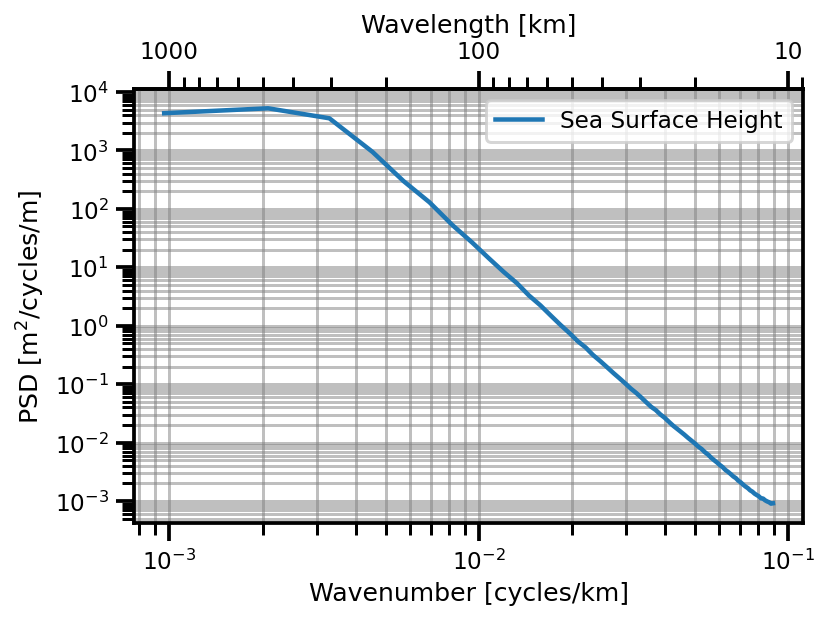

In [25]:
fig, ax = psd_plots.plot_psd(ds_psd, 1e3, 1)

## Reconstruction Datasets

In [16]:
# download_ssh_toy("4dvarnet")
# # download_ssh_toy("duacs")
# download_ssh_toy("miost")

In [17]:
# NATL60
ds_grid = xr.open_dataset("/Volumes/EMANS_HDD/data/osse_oceanix/raw/sim/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc", decode_times=False).assign_coords(time=lambda ds: pd.to_datetime(ds.time))


ds_ssh = ds_grid.ssh

# convert lat/lon, degrees -> meters
ds_ssh = spatial.coords_degree_2_meters(ds_ssh)

# convert time stamps -> days
ds_ssh = temporal.coords_temporal_normalize(ds_ssh, np.timedelta64(1, "D"))

ds_psd_natl60 = psd_transform.isotropic_power_spectrum_dask(ds_ssh)

ds_psd_natl60.attrs["label"] = "NATL60"

[########################################] | 100% Completed |  8.2s


In [18]:

# DUACS Reconstruction
ds_grid = xr.open_dataset('/Volumes/EMANS_HDD/data/osse_oceanix/raw/results/duacs/ssh_NATL60_swot_4nadir.nc')

ds_ssh = ds_grid.ssh_mod
# convert lat/lon, degrees -> meters
ds_ssh = spatial.coords_degree_2_meters(ds_ssh)

# convert time stamps -> days
ds_ssh = temporal.coords_temporal_normalize(ds_ssh, np.timedelta64(1, "D"))


ds_psd_oi = psd_transform.isotropic_power_spectrum_dask(ds_ssh)

[########################################] | 100% Completed | 10.2s


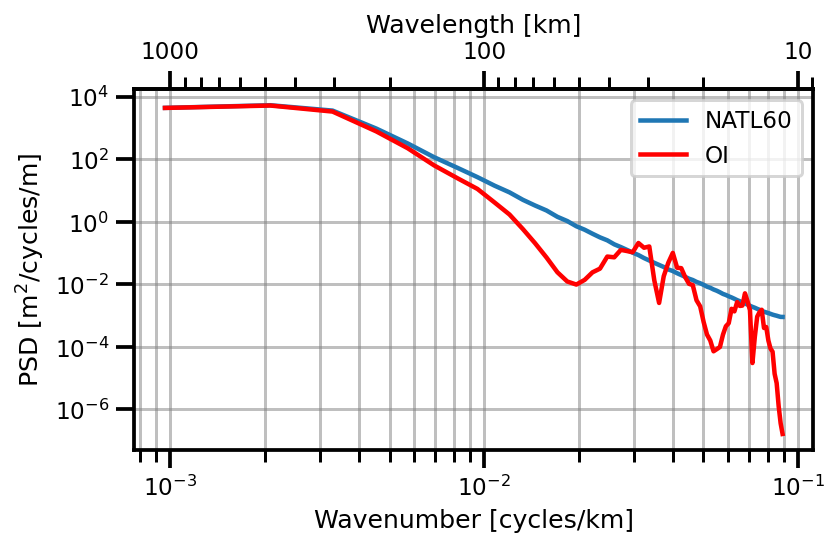

In [19]:
fig, ax = psd_plots.plot_psd(ds_psd_natl60)

ax.plot( 
    ds_psd_oi.freq_r,
    ds_psd_oi,
    label="OI", color="red"
)


ax.legend()
ax.grid(which="both", alpha=0.5, color="gray")

plt.tight_layout()
plt.show()